# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

# use this to temporarily address crashes due to matplotlib and OpenMP
# "OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized."
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])
    # get training and test directories
    image_path = './' + data_dir
    #train_path = os.path.join(image_path, image_type)
    
    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(image_path, transform)
    
    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 8
img_size   = 32  

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

C:\Users\wc5257\AppData\Local\Temp/ipykernel_3572/3605241019.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


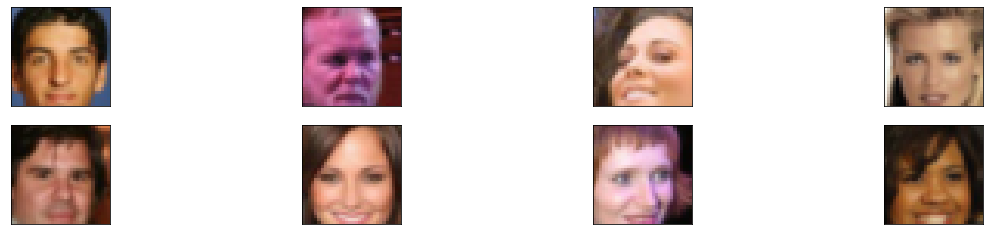

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))

# plot_size needs to be either plot_size=20 or batch_size, which ever is less
default_plot_size = 20
if batch_size < default_plot_size:
    plot_size = batch_size
else:
    plot_size=20 # this needs to be either plot_size=20 or batch_size, which ever is less
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    # xnormalized=(b−a)*((x−min(x)) / (max(x)−min(x))) + a
    # a, b, max(x)=1, min(x)=0 -> (b-a)(x-0)/(1-0)  + a -> (max-min)(x) + min 
    min, max = feature_range
    x = x*(max-min) + min 
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.9137)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        # input is (32,32,3)
        self.conv_dim = conv_dim
        
        self.conv1    = conv(3, conv_dim, 4, batch_norm=False)          # kernel size 4 as recommended above, no batch
        self.conv2    = conv(conv_dim, conv_dim*2, 4, batch_norm=True)  # use batch normalization
        self.conv3    = conv(conv_dim*2, conv_dim*4, 4, batch_norm=True)# use batch normalization
        
        self.fc       = nn.Linear(conv_dim*4*4*4, 1)                    # size = conv_dim*4 * the other two dimensions
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # complete forward function
                                            # x is torch.Size([128, 3, 32, 32])
        x = F.leaky_relu(self.conv1(x))     # x is torch.Size([128, 32, 16, 16]) 
        x = F.leaky_relu(self.conv2(x))     # x is torch.Size([128, 64, 8, 8]
        x = F.leaky_relu(self.conv3(x))     # x is torch.Size([128, 128, 4, 4])
        x = x.view(-1, self.conv_dim*4*4*4) # need to flatten to input size of fc
                                            # x is torch.Size([128, 2048])
        x = self.fc(x)                      # x is torch.Size([128, 1])
        #print(x.size())
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(t_conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim                                           # if conv_dim=32 & batch_size=8
                                                                           # [8,100]  
        self.fc       = nn.Linear(z_size, conv_dim*4*4*4)                  # In [8, 100]        Out [8, 2048]
        self.tconv1   = deconv(conv_dim*4, conv_dim*2, 4, batch_norm=True) # In [8,128,  4,  4] Out [8, 64,  8,  8]
        self.tconv2   = deconv(conv_dim*2, conv_dim, 4, batch_norm=True)   # In [8, 64,  8,  8] Out [8, 32, 16, 16]
        self.tconv3   = deconv(conv_dim, 3, 4, batch_norm=False)           # In [8, 32, 16, 16] Out [8,  3, 32, 32]

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
                                             # x is torch.Size([8, 100])
        x = self.fc(x)                       # x is torch.Size([8, 2048])
        x = x.view(-1,self.conv_dim*4, 4, 4) # x is torch.Size([8, 128,  4,  4])
        x = F.relu(self.tconv1(x))           # x is torch.Size([8,  64,  8,  8])
        x = F.relu(self.tconv2(x))           # x is torch.Size([8,  32, 16, 16])
        x = self.tconv3(x)                   # x is torch.Size([8,   3, 32, 32])
        x = F.tanh(x)                        # x is torch.Size([8,   3, 32, 32])
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


C:\Users\wc5257\Anaconda3\envs\tf_gpu_3_torch\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    std = .02    
    # for every Linear and Convolutional layer in a model..
    if classname.find('Linear') or classname.find('Conv2d') != -1:
        m.weight.data.normal_(0, std)
        m.bias.data.fill_(0)   

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    #D.apply(weights_init_normal)
    #G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size     = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=F

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False # for debug
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G

# params
lr = .0002  # from the referenced paper
beta1=.5    # from the referenced paper
beta2=.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()

            # 1. Train the discriminator on real and fake images
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [24]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs, print_every=500)

Epoch [    1/  100] | d_loss: 0.8821 | g_loss: 0.9604
Epoch [    1/  100] | d_loss: 0.3714 | g_loss: 2.8835
Epoch [    1/  100] | d_loss: 0.5227 | g_loss: 2.6760
Epoch [    1/  100] | d_loss: 0.7873 | g_loss: 1.9521
Epoch [    1/  100] | d_loss: 0.6486 | g_loss: 1.9428
Epoch [    1/  100] | d_loss: 0.1583 | g_loss: 1.8748
Epoch [    1/  100] | d_loss: 0.8901 | g_loss: 0.7658
Epoch [    1/  100] | d_loss: 0.2280 | g_loss: 2.5906
Epoch [    1/  100] | d_loss: 0.1983 | g_loss: 2.1943
Epoch [    1/  100] | d_loss: 0.6811 | g_loss: 2.0673
Epoch [    1/  100] | d_loss: 0.8983 | g_loss: 2.1575
Epoch [    1/  100] | d_loss: 0.3388 | g_loss: 1.3305
Epoch [    1/  100] | d_loss: 0.7336 | g_loss: 2.4457
Epoch [    1/  100] | d_loss: 0.4031 | g_loss: 1.5522
Epoch [    1/  100] | d_loss: 0.7604 | g_loss: 0.9128
Epoch [    1/  100] | d_loss: 0.2627 | g_loss: 2.6603
Epoch [    2/  100] | d_loss: 1.5737 | g_loss: 1.9118
Epoch [    2/  100] | d_loss: 0.8616 | g_loss: 2.3999
Epoch [    2/  100] | d_loss

Epoch [   10/  100] | d_loss: 0.1360 | g_loss: 3.1102
Epoch [   10/  100] | d_loss: 0.2516 | g_loss: 2.8729
Epoch [   10/  100] | d_loss: 0.5751 | g_loss: 2.6728
Epoch [   10/  100] | d_loss: 0.2049 | g_loss: 1.9022
Epoch [   10/  100] | d_loss: 0.2577 | g_loss: 4.1846
Epoch [   10/  100] | d_loss: 0.1070 | g_loss: 3.0209
Epoch [   10/  100] | d_loss: 0.6715 | g_loss: 2.1361
Epoch [   10/  100] | d_loss: 0.5748 | g_loss: 2.6249
Epoch [   11/  100] | d_loss: 1.2982 | g_loss: 1.6471
Epoch [   11/  100] | d_loss: 0.0462 | g_loss: 4.8288
Epoch [   11/  100] | d_loss: 0.1271 | g_loss: 3.7493
Epoch [   11/  100] | d_loss: 0.1085 | g_loss: 4.0805
Epoch [   11/  100] | d_loss: 0.3641 | g_loss: 2.3623
Epoch [   11/  100] | d_loss: 0.2098 | g_loss: 1.0620
Epoch [   11/  100] | d_loss: 0.3074 | g_loss: 3.8632
Epoch [   11/  100] | d_loss: 0.0495 | g_loss: 3.9384
Epoch [   11/  100] | d_loss: 0.5634 | g_loss: 2.1623
Epoch [   11/  100] | d_loss: 0.1453 | g_loss: 3.5440
Epoch [   11/  100] | d_loss

Epoch [   20/  100] | d_loss: 0.4040 | g_loss: 4.0011
Epoch [   20/  100] | d_loss: 0.2727 | g_loss: 6.4082
Epoch [   20/  100] | d_loss: 0.4752 | g_loss: 4.1792
Epoch [   20/  100] | d_loss: 0.3360 | g_loss: 3.1265
Epoch [   20/  100] | d_loss: 0.6128 | g_loss: 2.7489
Epoch [   20/  100] | d_loss: 0.0585 | g_loss: 2.8299
Epoch [   20/  100] | d_loss: 0.2079 | g_loss: 4.6327
Epoch [   20/  100] | d_loss: 0.1645 | g_loss: 4.3880
Epoch [   20/  100] | d_loss: 0.0631 | g_loss: 5.9617
Epoch [   20/  100] | d_loss: 0.4527 | g_loss: 3.2435
Epoch [   20/  100] | d_loss: 0.4255 | g_loss: 3.2220
Epoch [   20/  100] | d_loss: 0.0807 | g_loss: 3.0439
Epoch [   20/  100] | d_loss: 0.2131 | g_loss: 3.6492
Epoch [   20/  100] | d_loss: 0.2632 | g_loss: 2.4089
Epoch [   20/  100] | d_loss: 0.0382 | g_loss: 5.5077
Epoch [   20/  100] | d_loss: 0.1130 | g_loss: 2.5724
Epoch [   21/  100] | d_loss: 0.0377 | g_loss: 3.9236
Epoch [   21/  100] | d_loss: 0.3931 | g_loss: 3.3191
Epoch [   21/  100] | d_loss

Epoch [   29/  100] | d_loss: 0.2128 | g_loss: 3.1959
Epoch [   29/  100] | d_loss: 0.0021 | g_loss: 4.9143
Epoch [   29/  100] | d_loss: 0.2417 | g_loss: 3.7986
Epoch [   29/  100] | d_loss: 0.0556 | g_loss: 5.5758
Epoch [   29/  100] | d_loss: 0.1012 | g_loss: 2.3269
Epoch [   29/  100] | d_loss: 0.1209 | g_loss: 5.9708
Epoch [   29/  100] | d_loss: 0.0306 | g_loss: 4.0153
Epoch [   29/  100] | d_loss: 0.0796 | g_loss: 6.1979
Epoch [   30/  100] | d_loss: 0.2039 | g_loss: 3.9751
Epoch [   30/  100] | d_loss: 0.3359 | g_loss: 3.0742
Epoch [   30/  100] | d_loss: 0.1264 | g_loss: 4.4473
Epoch [   30/  100] | d_loss: 0.0742 | g_loss: 4.7199
Epoch [   30/  100] | d_loss: 0.1288 | g_loss: 4.5037
Epoch [   30/  100] | d_loss: 1.2061 | g_loss: 4.1103
Epoch [   30/  100] | d_loss: 0.2628 | g_loss: 4.3529
Epoch [   30/  100] | d_loss: 0.5797 | g_loss: 2.2327
Epoch [   30/  100] | d_loss: 0.3807 | g_loss: 2.8384
Epoch [   30/  100] | d_loss: 0.1344 | g_loss: 3.5862
Epoch [   30/  100] | d_loss

Epoch [   39/  100] | d_loss: 0.0072 | g_loss: 5.6159
Epoch [   39/  100] | d_loss: 0.0597 | g_loss: 5.2510
Epoch [   39/  100] | d_loss: 0.1869 | g_loss: 6.3483
Epoch [   39/  100] | d_loss: 0.1631 | g_loss: 6.9711
Epoch [   39/  100] | d_loss: 0.1059 | g_loss: 7.7162
Epoch [   39/  100] | d_loss: 0.2809 | g_loss: 6.0433
Epoch [   39/  100] | d_loss: 0.3013 | g_loss: 8.1734
Epoch [   39/  100] | d_loss: 0.1968 | g_loss: 2.8561
Epoch [   39/  100] | d_loss: 0.7905 | g_loss: 4.9365
Epoch [   39/  100] | d_loss: 0.1546 | g_loss: 2.1217
Epoch [   39/  100] | d_loss: 0.1545 | g_loss: 5.2390
Epoch [   39/  100] | d_loss: 0.0232 | g_loss: 4.9133
Epoch [   39/  100] | d_loss: 0.6579 | g_loss: 4.1378
Epoch [   39/  100] | d_loss: 0.0177 | g_loss: 6.0829
Epoch [   39/  100] | d_loss: 0.1638 | g_loss: 3.6152
Epoch [   39/  100] | d_loss: 0.2252 | g_loss: 3.6571
Epoch [   40/  100] | d_loss: 0.1083 | g_loss: 3.1612
Epoch [   40/  100] | d_loss: 0.1491 | g_loss: 5.8492
Epoch [   40/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.9364 | g_loss: 3.2142
Epoch [   48/  100] | d_loss: 0.2937 | g_loss: 4.6007
Epoch [   48/  100] | d_loss: 0.0157 | g_loss: 3.3798
Epoch [   48/  100] | d_loss: 0.2413 | g_loss: 5.1837
Epoch [   48/  100] | d_loss: 0.0402 | g_loss: 3.5942
Epoch [   48/  100] | d_loss: 0.0416 | g_loss: 4.5926
Epoch [   48/  100] | d_loss: 0.2032 | g_loss: 5.7656
Epoch [   48/  100] | d_loss: 0.0125 | g_loss: 5.4247
Epoch [   49/  100] | d_loss: 0.0879 | g_loss: 6.1381
Epoch [   49/  100] | d_loss: 0.0047 | g_loss: 4.1958
Epoch [   49/  100] | d_loss: 0.1932 | g_loss: 6.1641
Epoch [   49/  100] | d_loss: 0.0605 | g_loss: 7.1324
Epoch [   49/  100] | d_loss: 0.3455 | g_loss: 6.2095
Epoch [   49/  100] | d_loss: 0.2245 | g_loss: 5.0626
Epoch [   49/  100] | d_loss: 0.0796 | g_loss: 4.6787
Epoch [   49/  100] | d_loss: 0.1141 | g_loss: 4.2057
Epoch [   49/  100] | d_loss: 0.1303 | g_loss: 4.4853
Epoch [   49/  100] | d_loss: 0.0367 | g_loss: 5.6509
Epoch [   49/  100] | d_loss

Epoch [   58/  100] | d_loss: 0.0150 | g_loss: 4.0544
Epoch [   58/  100] | d_loss: 0.0006 | g_loss: 8.5776
Epoch [   58/  100] | d_loss: 0.8966 | g_loss: 4.3182
Epoch [   58/  100] | d_loss: 0.1195 | g_loss: 4.4177
Epoch [   58/  100] | d_loss: 0.0134 | g_loss: 5.9466
Epoch [   58/  100] | d_loss: 0.0178 | g_loss: 6.0449
Epoch [   58/  100] | d_loss: 0.0217 | g_loss: 3.6116
Epoch [   58/  100] | d_loss: 0.0036 | g_loss: 6.7977
Epoch [   58/  100] | d_loss: 0.0069 | g_loss: 7.9240
Epoch [   58/  100] | d_loss: 0.1044 | g_loss: 6.5526
Epoch [   58/  100] | d_loss: 0.1712 | g_loss: 6.0187
Epoch [   58/  100] | d_loss: 0.0910 | g_loss: 5.6386
Epoch [   58/  100] | d_loss: 0.0347 | g_loss: 4.8430
Epoch [   58/  100] | d_loss: 0.0671 | g_loss: 8.2669
Epoch [   58/  100] | d_loss: 0.4630 | g_loss: 6.4274
Epoch [   58/  100] | d_loss: 0.1320 | g_loss: 2.8164
Epoch [   59/  100] | d_loss: 0.0031 | g_loss: 9.2641
Epoch [   59/  100] | d_loss: 0.0223 | g_loss: 2.1151
Epoch [   59/  100] | d_loss

Epoch [   67/  100] | d_loss: 0.0155 | g_loss: 9.2481
Epoch [   67/  100] | d_loss: 0.1875 | g_loss: 6.3192
Epoch [   67/  100] | d_loss: 0.1884 | g_loss: 7.0660
Epoch [   67/  100] | d_loss: 0.1535 | g_loss: 5.3660
Epoch [   67/  100] | d_loss: 0.0488 | g_loss: 4.4900
Epoch [   67/  100] | d_loss: 0.0081 | g_loss: 5.0135
Epoch [   67/  100] | d_loss: 0.0172 | g_loss: 5.8583
Epoch [   67/  100] | d_loss: 0.0917 | g_loss: 4.7199
Epoch [   68/  100] | d_loss: 0.0275 | g_loss: 5.1434
Epoch [   68/  100] | d_loss: 0.1628 | g_loss: 5.2418
Epoch [   68/  100] | d_loss: 0.1522 | g_loss: 4.6797
Epoch [   68/  100] | d_loss: 0.0079 | g_loss: 7.1556
Epoch [   68/  100] | d_loss: 0.0342 | g_loss: 8.9016
Epoch [   68/  100] | d_loss: 0.0942 | g_loss: 1.5554
Epoch [   68/  100] | d_loss: 0.1040 | g_loss: 6.5392
Epoch [   68/  100] | d_loss: 0.2221 | g_loss: 12.0521
Epoch [   68/  100] | d_loss: 0.1768 | g_loss: 6.8920
Epoch [   68/  100] | d_loss: 0.0388 | g_loss: 7.7481
Epoch [   68/  100] | d_los

Epoch [   77/  100] | d_loss: 0.2999 | g_loss: 7.2283
Epoch [   77/  100] | d_loss: 0.0295 | g_loss: 7.0837
Epoch [   77/  100] | d_loss: 0.0446 | g_loss: 9.6449
Epoch [   77/  100] | d_loss: 0.0008 | g_loss: 5.8568
Epoch [   77/  100] | d_loss: 0.0515 | g_loss: 8.2061
Epoch [   77/  100] | d_loss: 0.0953 | g_loss: 3.9337
Epoch [   77/  100] | d_loss: 0.0089 | g_loss: 7.7920
Epoch [   77/  100] | d_loss: 0.0767 | g_loss: 4.0358
Epoch [   77/  100] | d_loss: 0.2065 | g_loss: 8.3751
Epoch [   77/  100] | d_loss: 0.1555 | g_loss: 6.9125
Epoch [   77/  100] | d_loss: 0.1951 | g_loss: 8.6916
Epoch [   77/  100] | d_loss: 0.3000 | g_loss: 6.7847
Epoch [   77/  100] | d_loss: 0.0204 | g_loss: 6.0062
Epoch [   77/  100] | d_loss: 0.0150 | g_loss: 3.7121
Epoch [   77/  100] | d_loss: 0.0733 | g_loss: 3.4967
Epoch [   77/  100] | d_loss: 0.6226 | g_loss: 6.8432
Epoch [   78/  100] | d_loss: 0.0847 | g_loss: 6.4111
Epoch [   78/  100] | d_loss: 0.0170 | g_loss: 7.3181
Epoch [   78/  100] | d_loss

Epoch [   86/  100] | d_loss: 0.0008 | g_loss: 7.5963
Epoch [   86/  100] | d_loss: 0.0049 | g_loss: 6.2922
Epoch [   86/  100] | d_loss: 0.3256 | g_loss: 2.9715
Epoch [   86/  100] | d_loss: 0.0284 | g_loss: 6.8029
Epoch [   86/  100] | d_loss: 0.0026 | g_loss: 6.8495
Epoch [   86/  100] | d_loss: 0.0169 | g_loss: 3.2535
Epoch [   86/  100] | d_loss: 0.0017 | g_loss: 4.7495
Epoch [   86/  100] | d_loss: 0.0561 | g_loss: 6.8463
Epoch [   87/  100] | d_loss: 0.0606 | g_loss: 8.8326
Epoch [   87/  100] | d_loss: 0.0004 | g_loss: 6.4680
Epoch [   87/  100] | d_loss: 0.1780 | g_loss: 5.3759
Epoch [   87/  100] | d_loss: 0.0065 | g_loss: 6.0510
Epoch [   87/  100] | d_loss: 0.2156 | g_loss: 1.8477
Epoch [   87/  100] | d_loss: 0.0229 | g_loss: 8.1046
Epoch [   87/  100] | d_loss: 0.0740 | g_loss: 6.2194
Epoch [   87/  100] | d_loss: 0.1173 | g_loss: 5.2274
Epoch [   87/  100] | d_loss: 0.0288 | g_loss: 7.5405
Epoch [   87/  100] | d_loss: 0.0013 | g_loss: 4.9191
Epoch [   87/  100] | d_loss

Epoch [   96/  100] | d_loss: 0.0069 | g_loss: 6.3664
Epoch [   96/  100] | d_loss: 0.0037 | g_loss: 6.7884
Epoch [   96/  100] | d_loss: 0.1149 | g_loss: 1.7270
Epoch [   96/  100] | d_loss: 0.0054 | g_loss: 5.8498
Epoch [   96/  100] | d_loss: 0.1359 | g_loss: 8.9924
Epoch [   96/  100] | d_loss: 0.5101 | g_loss: 4.7572
Epoch [   96/  100] | d_loss: 0.9695 | g_loss: 5.1002
Epoch [   96/  100] | d_loss: 0.0282 | g_loss: 3.9780
Epoch [   96/  100] | d_loss: 0.1765 | g_loss: 6.6956
Epoch [   96/  100] | d_loss: 0.1288 | g_loss: 7.7525
Epoch [   96/  100] | d_loss: 0.0068 | g_loss: 8.7736
Epoch [   96/  100] | d_loss: 0.0670 | g_loss: 8.5470
Epoch [   96/  100] | d_loss: 0.0035 | g_loss: 7.7731
Epoch [   96/  100] | d_loss: 0.0210 | g_loss: 5.5640
Epoch [   96/  100] | d_loss: 0.0033 | g_loss: 6.2555
Epoch [   96/  100] | d_loss: 0.0838 | g_loss: 8.2627
Epoch [   97/  100] | d_loss: 0.0221 | g_loss: 6.9344
Epoch [   97/  100] | d_loss: 0.0144 | g_loss: 5.4890
Epoch [   97/  100] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

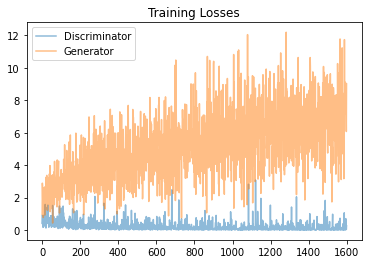

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

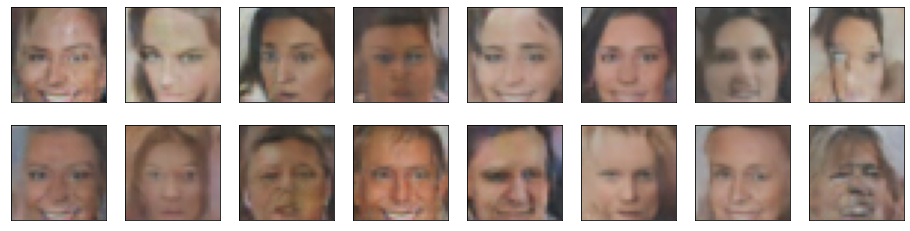

In [28]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

Initial Parameters
>- batch_size = 8
>- img_size = 32
>- d_conv_dim = 32
>- g_conv_dim = 32
>- z_size     = 100
>- lr = .0002
>- beta1 =.5
>- beta2 =.999
>- epochs = 100

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.